# Sense Stock Big Data Pipeline

# 1. BDM Pipeline Overview


<img src="docs/BDM_PRO_2.png"> 
<!-- <img src="DOCS/student_data_analysis.png", width = 500, height = 400>  -->


In [1]:
# import libraries
import pymongo
import pandas as pd
import os
import json
import time
# import mplfinance as fplt
from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display, HTML
import seaborn as sns
%matplotlib inline
# from ipywidgets import widgets


from pyspark.sql import SparkSession
import pandas as pd
import os 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# to connect from VM system
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")

In [3]:
#path from where we will read files for one hour 
path = '/home/bdm/data_sources/stock_data_parquet/'
appName = "stock parquet files"
spark = SparkSession.builder.appName(appName).getOrCreate()

/home/bdm/.local/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [4]:
# define Database
tweetdb = mongo_client["sense_stock_db"]['tweet_data']

In [12]:
# function to get real-time of India with 5 minute buffer 

def get_time():
    # get todays date according to indian timezone
    IN_time = pd.Timestamp.now('Asia/Kolkata')-pd.Timedelta(minutes=5)
    # IN_time = pd.Timestamp.now('Asia/Kolkata')-pd.Timedelta(days=5)
    # IN_time = IN_time-pd.Timedelta(hours=5)
    
    date = str(IN_time.date()).replace("-","_")
    #date = "2022_06_03"

    hour = int(IN_time.hour)
    #hour = 21

    minute = int(IN_time.minute)

    return date,hour,minute

In [7]:
def display_tweets(date,hour,minute,company="RELIENCE"):
    # run query to extract result
    myquery = { "date": date , "companies":company, "hour":hour, "minute":minute}
    mydoc = tweetdb.find(myquery)
    for x in mydoc:
        print("Extracted data")
        df = pd.DataFrame(x['top_N_tweets'])
    display(HTML(df.to_html()))

In [8]:
def display_stocks(date,hour,minute,company="RELIENCE"):
    date_ = os.path.join(path,date)
    parquet_name = 'stock_data'+'_'+str(hour)+'_'+str(minute)+'.parquet'
    file_name = os.path.join(date_,parquet_name)
    print(file_name)
    df1 = spark.read.parquet(file_name)
    df2 = df1.select('symbol','lastPrice','dayHigh','dayLow','closePrice','open')
    pd_df = df2.toPandas()
    df_cmp = pd_df[pd_df['symbol']==company]
    print(df_cmp)
    # display(HTML(df_cmp.to_html()))

In [9]:
def get_datetime(df_cmp):
    tm = df_cmp.iloc[0]['timestamp']+'_'+df_cmp.iloc[0]['hour']+'_'+df_cmp.iloc[0]['minute']
    datetime_object = datetime.strptime(tm, "%Y_%m_%d_%H_%M")
    return datetime_object

### Exploitation Zone

**We are displaying/plotting stock as well as tweet data for a company each minute in real time**

In [ ]:
# display top tweets and stocks for entered company each minute
stock_combined_df = pd.DataFrame(columns= ['timestamp', 'hour', 'minute', 'symbol', 'lastPrice', 'dayHigh',
       'dayLow', 'closePrice', 'open', 'date_time'])
tweet_combined_df = pd.DataFrame(columns = ['polarity', 'timestamp', 'sentiment', 'text', 'date_time'])


# define company
company = "ZOMATO"

Top tweets for date - 2022_06_11 hour 18 and minute 49 for company RELIANCE


,timestamp,hour,minute,symbol,lastPrice,dayHigh,dayLow,closePrice,open,date_time
0,2022_06_11,18,49,RELIANCE,2713.9,2789.9,2701.5,2714.25,2771.9,2022-06-11 18:49:00


,polarity,timestamp,sentiment,text,date_time
0,0.0,2022-06-11 13:19:08.292,Neutral,@rishhikesh @KirenRijiju @Kangana_team0 @livemint @dna please stop Reliance from looting Bigbazaar.\n#Futureretail https://t.co/eCFpSFGnM1,2022-06-11 18:45:00
1,0.0,2022-06-11 13:19:17.306,Neutral,@brajeshpathakup @PMOIndia @BJP4India @BJP4UP @CMOfficeUP @Kangana_team0 @livemint @dna please stop Reliance from l… https://t.co/fBAR40UQYX,2022-06-11 18:45:00
2,0.0,2022-06-11 13:19:54.035,Neutral,"RT @MinistrOfAsmara: Hey .@Futurical,\nTHREAD!\nHow US adopted #Eritrea's self-reliance policy:\n\nThis is #Eritrea's #IsaiasAfwerki speaking a…",2022-06-11 18:45:00
3,0.0,2022-06-11 13:19:58.649,Neutral,RT @Deepak76597281: @brajeshpathakup @PMOIndia @BJP4India @Kangana_team0 @livemint @dna please stop Reliance from looting Bigbazaar.\n#Futur…,2022-06-11 18:45:00


KeyboardInterrupt: 

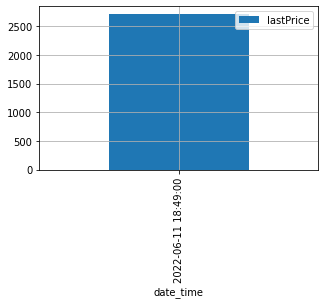

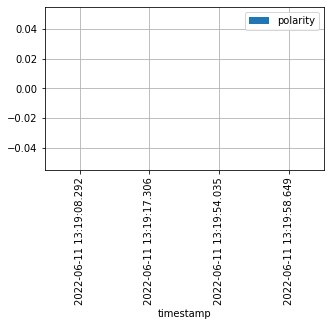

In [11]:
# run loop for displaying data with each minute break
while(True):
    
    # comp = input("Enter company name")
    # get time
    date,hour,minute = get_time()
    print("Top tweets for date - {} hour {} and minute {} for company {}".format(date,hour,minute, company))



    # Extract tweets
    try:
        myquery = { "date": date , "companies":company, "hour":hour, "minute":minute}
        mydoc = tweetdb.find(myquery)
        for x in mydoc:
            df = pd.DataFrame(x['top_N_tweets'])
            df = df[['polarity','timestamp','sentiment','text']]
            _datetw = get_datetime(df_cmp)
            df['date_time'] = _datetw
            tweet_combined_df = tweet_combined_df.append(df)
        # display(HTML(df.to_html()))
    except:
        pass
        
    
    
    # run query to diplay stocks
    try:
        date_ = os.path.join(path,date)
        parquet_name = 'stock_data'+'_'+str(hour)+'_'+str(minute)+'.parquet'
        file_name = os.path.join(date_,parquet_name)
        df1 = spark.read.parquet(file_name)
        df2 = df1.select('timestamp','hour','minute','symbol','lastPrice','dayHigh','dayLow','closePrice','open')
        pd_df = df2.toPandas()
        df_cmp = pd_df[pd_df['symbol']==company]
        _datetime = get_datetime(df_cmp)
        df_cmp['date_time'] = _datetime
        stock_combined_df = stock_combined_df.append(df_cmp)
    except:
        pass



    # diplay combined dataframe
    display(HTML(stock_combined_df.to_html()))
    display(HTML(tweet_combined_df.to_html()))
    

    # plot data 
    try:
        stock_combined_df.plot(x= 'date_time', y="lastPrice", kind="bar", figsize=(5, 3),grid=True)
    except:
        pass    
        
    try:
        tweet_combined_df['polarity'] = tweet_combined_df['polarity'].astype(float)
        tweet_combined_df.plot(x= 'timestamp', y="polarity", kind="bar", figsize=(5, 3),grid=True)
    except:
        pass
    
    # sleep for around 1 minute
    time.sleep(60)

# Extra

In [13]:
    # except:
    #     pass
        
    
    # combine the dataframe
    # stock_combined_df = stock_combined_df.append(df_cmp)
    # stock_combined_df_indx = stock_combined_df.set_index('date_time')
    # stock_combined_df_indx.rename(columns={'open': 'Open','dayHigh': 'High','dayLow': 'Low','closePrice': 'Close'}, inplace=True)
    # tweet_combined_df
    # fplt.plot(
    #         stock_combined_df_indx,
    #         type='candle',
    #         title='OHLC Plot',
    #         ylabel='Price (₹.)',
    #     )
    
    # display(HTML(df_cmp.to_html()))

In [23]:
# # display top tweets for entered company each minute
# while(True):
    
#     date,hour,minute = get_time()
#     # comp = input("Enter company name")
#     comp = "RELIENCE"
    
    
#     print(date,hour,minute, comp)

#     # run query to diplay tweets
#     try:
#         display_tweets(date,hour,minute,comp)
#     except:
#         print("No tweets in this minute")
    
#     # run query to diplay stocks
#     display_stocks(date,hour,minute,comp)
    
#     # sleep for around 1 minute
#     # time.sleep(60)
#     break

In [14]:
# while(True):
#     date,hour,min = get_time()
#     date_ = os.path.join(path,date)
#     parquet_name = 'stock_data'+'_'+str(hour)+'_'+str(min)+'.parquet'
#     file_name = os.path.join(date_,parquet_name)
#     print(file_name)
#     df1 = spark.read.parquet(file_name)
#     df2 = df1.select('symbol','lastPrice','dayHigh','dayLow','closePrice','open')
#     # df2.show()
#     pd_df = df2.toPandas()
#     df_cmp = pd_df[pd_df['symbol']==company]
#     display(HTML(df_cmp.to_html()))
    
    
#     break
# #/home/bdm/data_sources/stock_data_parquet/2022_06_05/stock_data2022_06_05_21_32.parquet

In [16]:
# display(HTML(df.to_html()))

In [18]:
# text = widgets.Text(description="Enter Company")
# display(text)

# # def process_results(sender):
# #     comp = text.value
# #     myquery = { "date": date , "companies":comp, "hour":hour, "minute":minute}
# #     mydoc = tweetdb.find(myquery)
# #     for x in mydoc:
# #         df = pd.DataFrame(x['top_N_tweets'])
# #         display(HTML(df.to_html()))


# # text.on_submit(process_results)

In [19]:
# # get todays date according to indian timezone
# # keeping buffer time to give time for processing (2 minutes)
# buffer_minutes = 2
# IN_time = pd.Timestamp.now('Asia/Kolkata')-pd.Timedelta(minutes=2)

# date = str(IN_time.date()).replace("-","_")
# date = "2022_06_03"

# hour = int(IN_time.hour)
# hour = 21

# minute = int(IN_time.minute)
# minute = 56



# # run query to extract result
# myquery = { "date": date , "companies":company, "hour":hour, "minute":minute}
# mydoc = tweetdb.find(myquery)
# for x in mydoc:
#     print("Extracted data")
#     df = pd.DataFrame(x['top_N_tweets'])
#     display(HTML(df.to_html()))

In [20]:
# # get todays date according to indian timezone
# # keeping buffer time to give time for processing (2 minutes)
# buffer_minutes = 2
# IN_time = pd.Timestamp.now('Asia/Kolkata')-pd.Timedelta(minutes=2)

# date = str(IN_time.date()).replace("-","_")
# date = "2022_06_03"

# hour = int(IN_time.hour)
# hour = 21

# minute = int(IN_time.minute)
# minute = 56



# # run query to extract result
# myquery = { "date": date , "companies":company, "hour":hour, "minute":minute}
# mydoc = tweetdb.find(myquery)
# for x in mydoc:
#     print("Extracted data")
#     df = pd.DataFrame(x['top_N_tweets'])
#     display(HTML(df.to_html()))

In [21]:
# # # display top tweets for entered company each minute
# # stock_combined_df = pd.DataFrame()

# # # run query to diplay stocks
# # for i in range(10):
# #     date,hour,minute = get_time(i)
# #     date_ = os.path.join(path,date)
# #     parquet_name = 'stock_data'+'_'+str(hour)+'_'+str(minute)+'.parquet'
# #     file_name = os.path.join(date_,parquet_name)
# #     df1 = spark.read.parquet(file_name)
# #     df2 = df1.select('timestamp','hour','minute','symbol','lastPrice','dayHigh','dayLow','closePrice','open')
# #     pd_df = df2.toPandas()
# #     df_cmp = pd_df[pd_df['symbol']==company]
# #     _datetime = get_datetime(df_cmp)
# #     df_cmp['date_time'] = _datetime
# #     stock_combined_df = stock_combined_df.append(df_cmp)
# # stock_combined_df
    
    
# # stock_combined_df = stock_combined_df.iloc[:,4:]
# # # convert to long (tidy) form
# # dfm = stock_combined_df.melt('date_time', var_name='cols', value_name='vals')
# # dfm
# # g = sns.relplot(x="date_time", y="vals", hue='cols', data=dfm, kind='line')
# # stock_combined_df.plot(x="date_time", y=["lastPrice"], kind="line", figsize=(8, 5),grid=True)
# #read all data of one hour
# def read_allFiles(FilenamesList,out_hr):
#     path = out_hr+'.parquet'
#     for f in FilenamesList:
#         df1 = spark.read.parquet(f)
#         #appending files of one hour
#         df1.write.mode('append').parquet(path)
# # for i in range(9,17):
# #     name = 'stock_data'+'2022_06_06'+'_'+str(i)
# #     location_hr = os.path.join(base_location_date,name)
# #     out_hr = os.path.join(outputpath,name)
# #     FilenamesList = glob(location_hr+'_*.parquet')
# #     for f in FilenamesList:
# #         df1 = spark.read.parquet(f)
# #         df2 = df1.to_Pandas()
# #         df2.head()
# #         break
# #         #appending files of one hour
        
    
# # name = 'stock_data'+date_str+'_'+hour
# # location_hr = os.path.join(base_location_date,name)
# # out_hr = os.path.join(outputpath,name)

# # FilenamesList = glob(location_hr+'_*.parquet')


In [22]:
# # run query to diplay stocks
# for i in range(10):
#     date,hour,minute = get_time(i)
#     date_ = os.path.join(path,date)
#     parquet_name = 'stock_data'+'_'+str(hour)+'_'+str(minute)+'.parquet'
#     file_name = os.path.join(date_,parquet_name)
#     df1 = spark.read.parquet(file_name)
#     df2 = df1.select('timestamp','hour','minute','symbol','lastPrice','dayHigh','dayLow','closePrice','open')
#     pd_df = df2.toPandas()
#     df_cmp = pd_df[pd_df['symbol']==company]
#     _datetime = get_datetime(df_cmp)
#     df_cmp['date_time'] = _datetime
#     stock_combined_df = stock_combined_df.append(df_cmp)
# stock_combined_df